In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/datasets/brain_tumor_dataset.zip

In [ ]:
!unzip /content/drive/MyDrive/datasets/predict.zip

In [ ]:
shutil.copytree("/content/brain_tumor_dataset/tumor","/content/temp",dirs_exist_ok=True)

'/content/temp'

In [ ]:
shutil.copytree("/content/brain_tumor_dataset/healthy","/content/temp",dirs_exist_ok=True)

'/content/temp'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import math
import seaborn as sns
from tensorflow.keras.callbacks import Callback,LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from prettytable import PrettyTable
import cv2
from tqdm import tqdm

In [46]:
ROOT_DIR = "/content/brain_tumor_dataset"

number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))
print(number_of_images.items())

dict_items([('tumor', 1299), ('healthy', 1300)])


In [26]:
parent = "tumor_vs_healthy/"
child_dirs = ["train/","validation/"]
for i in child_dirs:
  #create subdirectories for the 2 labels
  label_sub_dirs = ["tumor/","healthy"]
  for j in label_sub_dirs:
    newdir = parent + i + j
    os.makedirs(newdir,exist_ok=True)

In [27]:
print(len(os.listdir("/content/temp")))

2599


In [28]:
random.seed(1)  # to get possible similar set of random numbers each time

# defining 80-20 ratio of train-validation split
val_ratio=0.20
# copy the images from temp folder into respective subdirectories for train and validation
src_directory = "temp"
for file in os.listdir(src_directory):
  s = src_directory + "/" + file
  dst_dir = "train/"
  if random.random() < val_ratio:
    dst_dir = "validation/"
  if file.startswith("y"):
    d = parent + dst_dir + "tumor/" + file
    shutil.copyfile(s,d)
  elif file.startswith("n"):
    d = parent + dst_dir + "healthy/" + file
    shutil.copyfile(s,d)

In [29]:
print("train")
print("=======================")
print("healthy-->",len(os.listdir("tumor_vs_healthy/train/healthy")))
print("tumor-->",len(os.listdir("tumor_vs_healthy/train/tumor")))
print("=======================")
print("validation")
print("=======================")
print("healthy-->",len(os.listdir("tumor_vs_healthy/validation/healthy")))
print("tumor-->",len(os.listdir("tumor_vs_healthy/validation/tumor")))

train
healthy--> 1030
tumor--> 1048
validation
healthy--> 263
tumor--> 251


In [ ]:
BATCH_SIZE=32
TARGET_SIZE=(224,224)

datagen = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,
                              zoom_range=0.2,shear_range=0.2,horizontal_flip=True,
                              preprocessing_function=preprocess_input)

path = "/content/tumor_vs_healthy/train"
train_it = datagen.flow_from_directory(path,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
path = "/content/tumor_vs_healthy/validation"
validation_it = datagen.flow_from_directory(path,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)
test = "/content/tumor_vs_healthy/predict"
test_it = datagen.flow_from_directory(path,class_mode="binary",batch_size=BATCH_SIZE,target_size=TARGET_SIZE)

print(train_it.class_indices,validation_it.class_indices,test_it.class_indices)

In [42]:
# tf.keras.backend.clear_session()

# # loading the base-model
# model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
# # mark the loaded layers as not-trainable
# for layer in model.layers:
#   layer.trainable=False
# # adding new classifier layers
# flat = Flatten()(model.layers[-1].output)
# classifier = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(flat)
# output = Dense(units=1,activation="sigmoid")(classifier)
# # define the model
# model = Model(inputs=model.inputs,outputs=output)
# # compile the model
# model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# model.summary()

model=VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

# mark the loaded layers as not-trainable
for layer in model.layers:
  layer.trainable=False

# adding new classifier layers
flat = Flatten()(model.layers[-1].output)
classifier = Dense(units=512, activation='relu', kernel_initializer='he_uniform')(flat)
dropout = Dropout(0.5)(classifier)
dense_2 = Dense(units=256, activation='relu', kernel_initializer='he_uniform')(dropout)
dropout_2 = Dropout(0.5)(dense_2)
output = Dense(units=1, activation='sigmoid')(dropout_2)

# define the model
model = Model(inputs=model.inputs, outputs=output)

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [43]:
history = model.fit(train_it,steps_per_epoch=len(train_it),
                      validation_data=validation_it,validation_steps=len(validation_it),
                      epochs=30)

Epoch 1/30
65/65 [==============================] - 33s 479ms/step - loss: 14.0337 - accuracy: 0.7271 - val_loss: 2.3615 - val_accuracy: 0.8988
Epoch 2/30
65/65 [==============================] - 31s 472ms/step - loss: 3.5139 - accuracy: 0.8580 - val_loss: 0.4676 - val_accuracy: 0.9475
Epoch 3/30
65/65 [==============================] - 32s 484ms/step - loss: 1.8390 - accuracy: 0.8710 - val_loss: 0.2690 - val_accuracy: 0.9416
Epoch 4/30
65/65 [==============================] - 32s 485ms/step - loss: 0.9342 - accuracy: 0.8701 - val_loss: 0.2846 - val_accuracy: 0.9319
Epoch 5/30
65/65 [==============================] - 31s 471ms/step - loss: 0.5316 - accuracy: 0.8831 - val_loss: 0.1409 - val_accuracy: 0.9591
Epoch 6/30
65/65 [==============================] - 31s 473ms/step - loss: 0.4019 - accuracy: 0.8884 - val_loss: 0.1396 - val_accuracy: 0.9397
Epoch 7/30
65/65 [==============================] - 31s 478ms/step - loss: 0.3522 - accuracy: 0.8787 - val_loss: 0.1292 - val_accuracy: 0.941

In [44]:
_,acc = model.evaluate(test_it,steps=len(test_it))
print("Acc",np.round(acc*100,3),"%")

17/17 [==============================] - 2s 129ms/step - loss: 0.1136 - accuracy: 0.9591
Evaluation Accuracy on completely unseen test data-set= 95.914 %


In [47]:
model.save("/content/save_model",save_format="h5")

In [50]:
def predict_tumor(img_path):
    # load the image
    img = load_img(img_path, target_size=(224, 224))  #(224,224,3)
    plt.imshow(img)
    # convert to array
    img = img_to_array(img) #(224,224,3)
    # add batch size as a dimension 
    img = np.expand_dims(img, axis=0)  #(1,224,224,3)
    best = load_model("/content/save_model")
    if best.predict(img)[0][0]>0.4:
        print("The image indicates presence of Brain tumor")
    else:
        print("This is a Healthy Brain")
    print("Probability of classfication:",best.predict(img)[0][0])

1/1 [==============================] - 0s 148ms/step
This is a Healthy Brain
1/1 [==============================] - 0s 22ms/step
Probability of classfication: 1.9614134e-20
None


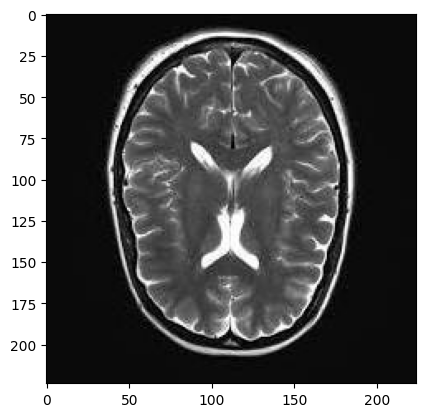

In [58]:
print(predict_tumor("/content/predict/healthy/no1491.jpg"))

1/1 [==============================] - 0s 149ms/step
The image indicates presence of Brain tumor
1/1 [==============================] - 0s 21ms/step
Probability of classfication: 0.9962949
None


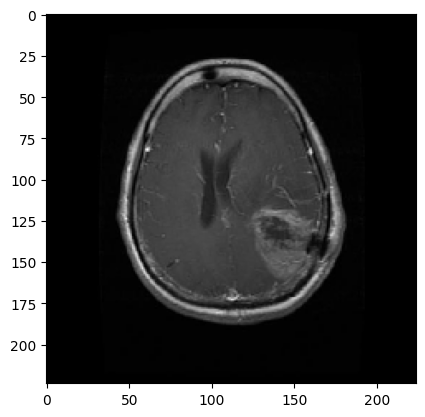

In [59]:
print(predict_tumor("/content/predict/tumor/y1394.jpg"))